## Concise: 1: Start and mesh
Author: yanjun zhang, Source from book "Abali - 2017 - Computational Reality" P119

def get_new_contact_nodes(x_co_zone, domain_pad, u_d, Vu, z1, x_co, y_co, S_rub_circle, i):
    # x_co_zone is the tolerance for contact range in z direction, z+ or z- x_contact_zone is range of contact condition
    gdim,fdim = 3,2
    original_co = domain_pad.geometry.x         # Initial coordinates of nodes (N x 3 array)
    u_d_vals    = u_d.x.array.reshape(-1, gdim) # Displacements (N x 3 array)
    deformed_co = original_co + u_d_vals        # Coordinates of deformed mesh

    low_contact_bool  =  (deformed_co[:, fdim] < (z1+x_co_zone)) 
    high_contact_bool =  (deformed_co[:, fdim] > (z1-x_co_zone)) 
    contact_boolean   =  low_contact_bool  &  high_contact_bool 
    contact_indices   =  np.where(contact_boolean)[0]  #contact indicies, from all nodes
    contact_co        =  original_co [ contact_indices ]
    #print('1: Minimum penalty deformation is ', min(u_d_vals[:,2]))
    #print('2: Length of contact indices is '  , len(contact_indices))
    #print('3: Length of u_d:  '               , len(deformed_co) )
    #print('4: Length of domain_pad: '         , len( original_co ) )
    #print('5: Length of contact_co: '         , len( contact_co  ) )

    if i == 0:
            S_rub_circle  = 1110.364507
            S_rub_circle1 = [S_rub_circle for _ in range(18) ] 
         else:
            S_rub_circle1 = S_rub_circle 

    #S_rub_circle = r_rub**2 * c_contact
    

    
    boundaries = []
    n_surface = len(S_rub_circle1)
    ## S_rub_circles1 should not change, it means the contact areas of rubbing elements, used to locate the boundaries.
    for j in range( n_surface): # boundaries include (marker, locator) 
            boundaries.append  ( lambda x,j=j: (x[0]-x_co[j])**2 +(x[1]-y_co[j])**2 <= S_rub_circle1[j])  
    contact_dofs = []  
    for j in range( n_surface):
            contact_dofs.append( fem.locate_dofs_geometrical(Vu, boundaries[j])  )
    ############################
    
    new_c_nodes = []
    for i in range( 18):
        contact_nodes_colum = deformed_co [contact_dofs [i]]  # column nodes, not only in surface
        tem_indi            = []
        new_contact         = []
        for j in range( len( contact_nodes_colum)):
            if ( contact_nodes_colum[j][2] <= (z1+x_co_zone) ) and ( contact_nodes_colum[j][2] >= (z1-x_co_zone) ):
                tem_indi = tem_indi + [j]   ## indices for contact_dofs, a column, only get surface index
            else:
                tem_indi = tem_indi 
          
        c1 = contact_dofs[i][tem_indi] # get index for contact surface
        new_c_nodes = new_c_nodes + [c1]
    return deformed_co, new_c_nodes
    
###########################################################

##################################################################################3
def get_r_xco_yco(deformed_co, new_c_nodes ):    
    x_co_new,y_co_new,r_rub_new1,r_rub_new = [],[],[],[]
    for i in range(18):
        z_nodes = []
        for j in range( len( deformed_co[ new_c_nodes[i]])):
            x = deformed_co[ new_c_nodes[ i]] [j] [0]
            y = deformed_co[ new_c_nodes[ i]] [j] [1]
            z_nodes[j:] =  [ [x,y] ]
        z_nodes    = np.array(z_nodes) 
        h1, k1, r1 = fit_circle(z_nodes)
        x_co_new   = x_co_new   + [h1]
        y_co_new   = y_co_new   + [k1]
        r_rub_new1 = r_rub_new1 + [r1] 

    no_0_r_rub = list(filter(lambda x: x!=0, r_rub_new1))  ## if contact points are 0, we do not add contact radius
    
    for i in range(18):
        if r_rub_new1[i] > 0: 
           #r_rub_new.append( r_rub_new1[i]  + (18.8 - np.average(no_0_r_rub) ) )
            r_rub_new.append( r_rub_new1[i]  )
        else:
            r_rub_new.append(0)

    #for i in range(18):
    #    r_co = np.sqrt(x_co_new[i]**2+y_co_new[i]**2)
    #    r_all1 = r_co - r_rub_new[i]
    #    r_all2 = r_co + r_rub_new[i]
        
    #    if  r_all1 <= 185:
    #        r_rub_new[i] =  16
    #    elif r_all2 >= 310:
    #        r_rub_new[i] =  16
    #    else:
    #        r_rub_new[i] = r_rub_new[i]  
    #print(r_rub_new)   
    
    for i in range(18):   
        if  r_rub_new[i] >= 18.8 :
            r_rub_new[i] = 18.5
        else:
            r_rub_new[i] = r_rub_new[i] 
            
    
    r_rub_new = np.array(r_rub_new)
    S_rub_circle_new = np.pi * r_rub_new**2      #specific contact surfaces
    S_total_new = np.sum(S_rub_circle_new) /100  #overall all contact surfaces
    return(x_co_new, y_co_new, r_rub_new, S_total_new, S_rub_circle_new)
###################################################################################   

DOLFINx version: 0.8.0
Simulation environment setup complete.
1: Total braking tims is  48.05 s
2: Total numb steps is  62
The file 'm-3-20.msh' exists, start creat now:
DOLFINx version: 0.8.0
Simulation environment setup complete.

1: Progress: 8.6%. Use time:             17 s. Start: 2024-11-15 16:40:03.      
t and T have been successfully saved as Result_T-s-10-d-2240-m-3-20-c-1-e-8476.csv


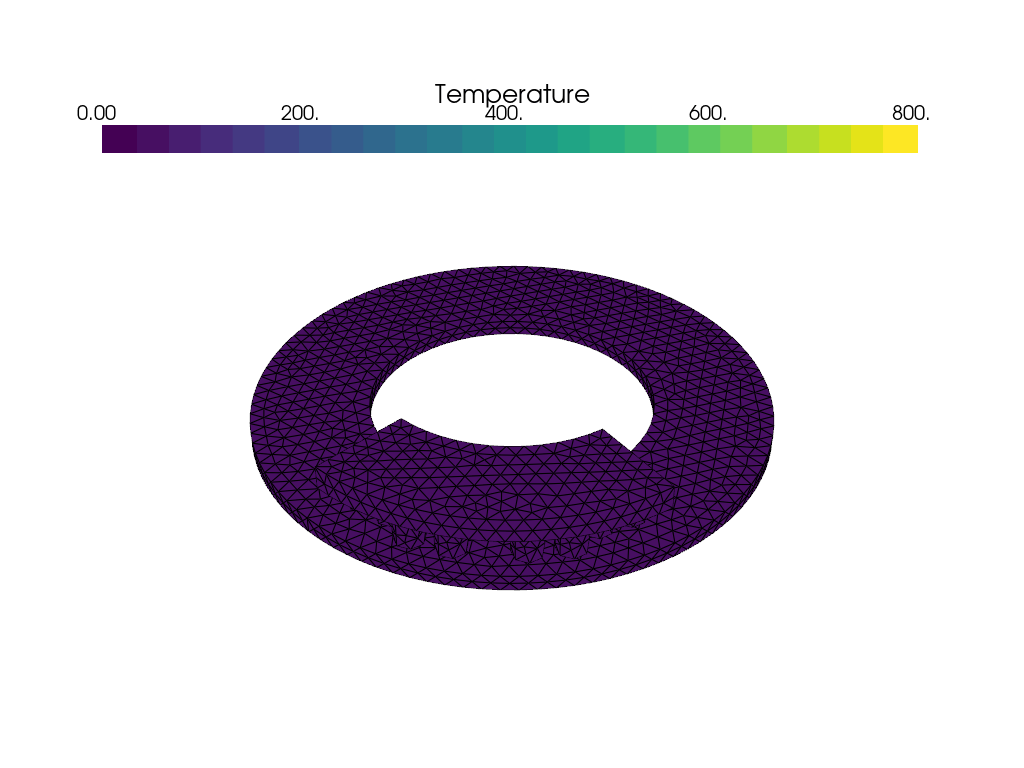

In [1]:
from disc_f1 import *


################################################################
def solve_heat(Ti, u_initial, num_steps, dt, x_co, y_co, angular_r, \
               t_brake, domain, S_rub_circle, fdim,\
               rho, c, v, radiation, k, h, f, Tm, g,\
               ds, xdmf, b_con, bc, plotter, warped,\
               mesh_name1, mesh_brake, pad_v_tag, z4,\
               z1, x_co_zone, u_n ):
  
    T_array = [(0, [Ti for _ in range(len(u_initial.x.array))])]
    total_degree = 0
    t = 0
    fraction_c = []
    for i in range(num_steps):
        
         t += dt[i]
        
         if i == 0: 
            u.x.array[:] = np.full(len(u_initial.x.array), 60)       
             
    
         total_degree += angular_r  # Incrementing degree in each step  

    
         # Construct the message     
         end_time = time.time()
         elapsed_time = end_time - start_time
         elapsed_time1 = round(elapsed_time, 0)
         formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
         if elapsed_time1 >= 60:
            min = elapsed_time1 / 60;       hours = min / 60
            progress_message = f"1: Progress: {round(100 * (t / t_brake), 1)}%. Use time: \
            {round(hours)} hours {round(min)} min. Start: {formatted_start_time }."
         else:
            progress_message = f"1: Progress: {round(100 * (t / t_brake), 1)}%. Use time: \
            {round(elapsed_time1)} s. Start: {formatted_start_time }."
         sys.stdout.write(f"\r{progress_message.ljust(80)}")  # 80 spaces to ensure full clearing
         sys.stdout.flush()


         S_rub_circle1 = [1110.364507] *18
         x_co, y_co = rub_rotation(x_co, y_co, angular_r) 
         #####################################
         co_ind, fa_mar, so_ind   = target_facets( domain, x_co, y_co, S_rub_circle1 )
         facet_tag                = meshtags( domain, fdim, co_ind[ so_ind], fa_mar[ so_ind] )
         ds                       = Measure( "ds", domain=domain, subdomain_data=facet_tag)
         #print(co_ind)     

         F = ((rho * c) / dt[i] * inner(u, v) * dx
             + k * inner(grad(u), grad(v)) * dx
             + h * inner(u, v) * ds(b_con)
             + radiation * inner(u**4, v) * ds(b_con)
             - ( inner(f, v) * dx
                 + (rho * c) / dt[i] * inner(u_n, v) * dx  #!!!!!!!!!!!!   u_n need to double check
                 + h * Tm * v * ds(b_con)
                 + radiation * (Tm**4) * v * ds(b_con)) )

         for j in list(range(1, 19)):
             #F += -k * dot(grad(u) * v, n_vector) * ds(10 * j) - inner(g[i], v) * ds(10 * j)
             F += ( - inner(g[i], v) * ds(10 * j) 
                    - h * inner( u, v) * ds(10 * j)  
                    - radiation * inner( (u**4 - Tm**4), v) * ds(10 * j) )    

         u_pre_solve = u.copy()         

         problem = NonlinearProblem(F, u, bcs=[bc])
         ## 7: Using petsc4py to create a linear solver
         solver_setup_solve(problem, u)
        
         u.x.scatter_forward()            
       
         # Update solution at previous time step (u_n)
         u_n.x.array[:] = u.x.array
         T_array.append((t, u.x.array.copy()))
         # Write solution to file
         xdmf.write_function(u, t)
         # Update plot
         #warped = grid.warp_by_scalar("uh", factor=0)
         plotter.update_coordinates(warped.points.copy(), render=False)
         plotter.update_scalars(u.x.array, render=False)
         plotter.write_frame()      

         #print('Rub radius is ', r_rub_new)

    plotter.close()
    xdmf.close()
    print()
    return(T_array, fraction_c )
###########################################################


# mesh-size, contact area coefficient
mesh_min, mesh_max = 3, 20
c_contact          = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r          = 2240
v_vehicle, c_acc   = 160, 1
z1,z2,z3,z4,z_all  = 20,33,30,83,8
pad_v_tag          = 32

# calling local functions to get all parameters
(dt, P, g, num_steps, h, radiation, v_angular, \
 Ti, Tm, S_rub_circle_ini, t, rho, c, k, t_brake, 
S_total,)                                       = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)
print("1: Total braking tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)

#g = g*500

## here use lots of abbreviation, details are in disc_f
domain, cell_markers, facet_markers, mesh_name, mesh_name1, mesh_name2 \
                       = mesh_brake_all(mesh_min,mesh_max,pad_v_tag)

V, T_init, u_n         = initial_u_n(domain, Ti)

fdim, bc, mesh_brake, all_e,xdmf, x_co, y_co, ds, b_con \
                       = mesh_setup( domain, V, mesh_name1, num_steps, \
                         angular_r, mesh_name2, c_contact, z_all, Tm, S_rub_circle_ini)
# Initialize
problem,u,v,f,n_vector = variation_initial(V, T_init, domain, rho, c, b_con,\
                          radiation, h, k, xdmf, dt, ds, u_n, Tm,g,bc);
solver_setup_solve(problem,u)

## Visualization of time dependent problem using pyvista
gif_name    = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, angular_r, mesh_name2, c_contact, all_e)
plotter, sargs, renderer, warped, viridis, grid = plot_gif(V,u,gif_name)
##solve
#num_steps= int(num_steps)
num_steps= int(10)
 
###################################################################
x_co_zone   = 0.05

T_array,fraction_c  = solve_heat(Ti, u, num_steps, dt, x_co, y_co, angular_r, \
               t_brake, domain, S_rub_circle_ini, fdim,\
               rho, c, v, radiation, k, h, f, Tm, g,\
               ds, xdmf, b_con, bc, plotter, warped,\
               mesh_name1, mesh_brake, pad_v_tag, z4,\
               z1, x_co_zone, u_n)  #last u should be u_n, here we set u, \
#the same with previous:solver_setup_solve(problem,u)
####################################################################

csv_name    = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(num_steps, angular_r, mesh_name2, c_contact, all_e  )
save_t_T(csv_name, T_array) # got the Temperature data

from IPython.display import display, Image
display(Image(gif_name))

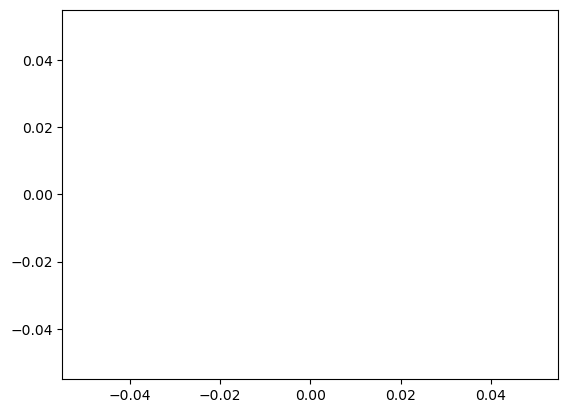

In [2]:
plt.plot(fraction_c)

<bound method Measure.ufl_domain of Measure('cell', subdomain_id='everywhere')>
